In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
cd drive/My\ Drive/Projects/Anomaly_Detection_Time_Series

/content/drive/My Drive/Projects/Anomaly_Detection_Time_Series


In [32]:
ls

 Anomaly_Detection/          forecasts/        PyTorch/
'Anomaly Detection README'   forecasts_old/    README.md
 data/                       nbeats_model.py   split_forecasts/
 DataAnalysis/               papers/           train_models/
 DTWBI/                      plots/            train_season_clusters.ipynb
'Energy Theft README'        preprocessing/    tune_models/


In [ ]:
!mv plots old_plots

In [1]:
import os
import json
import pickle
import matplotlib
import numpy as np
import pandas as po
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [2]:
df = po.read_csv('data/2017_energy_5min_noTransform.csv')

In [3]:
scaler = MinMaxScaler()
df_normalized = po.DataFrame(scaler.fit_transform(df), columns = ['W'])

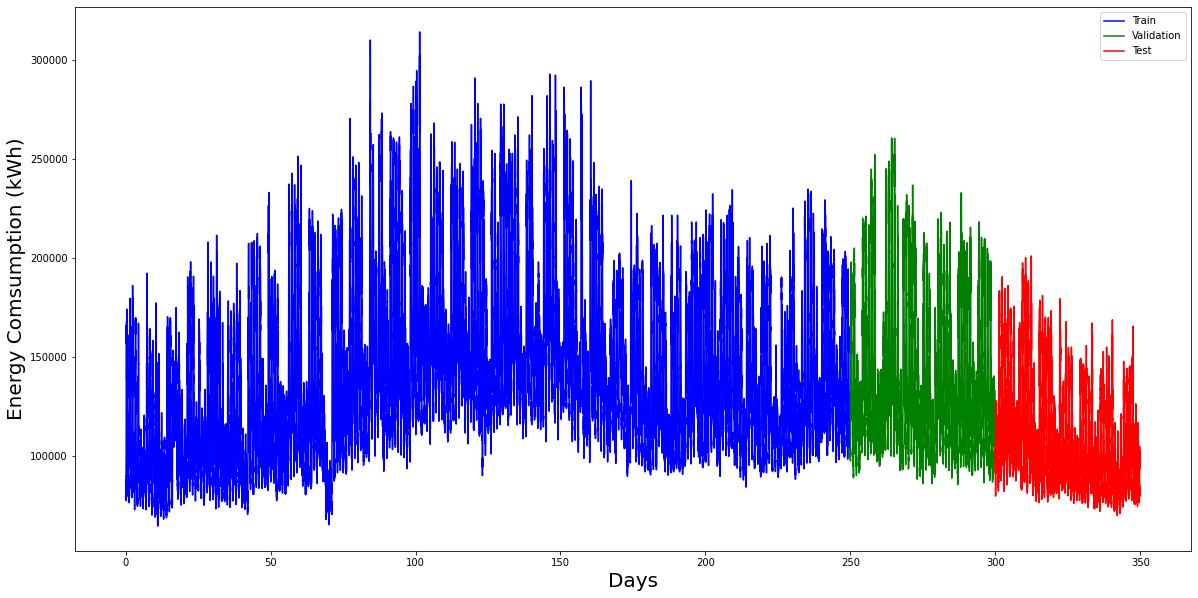

In [ ]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(df) + 1, 50*288)), labels = list(range(0, int(len(df)/288 + 1), 50)), size = 10)
plt.yticks(size = 10)
plt.plot(df[:288*250], color = 'blue')
plt.plot(df[288*250:288*300], color = 'green')
plt.plot(df[288*300:], color = 'red')
plt.legend(['Train', 'Validation', 'Test'])
plt.savefig('DataAnalysis/year_train_test_plot.png')

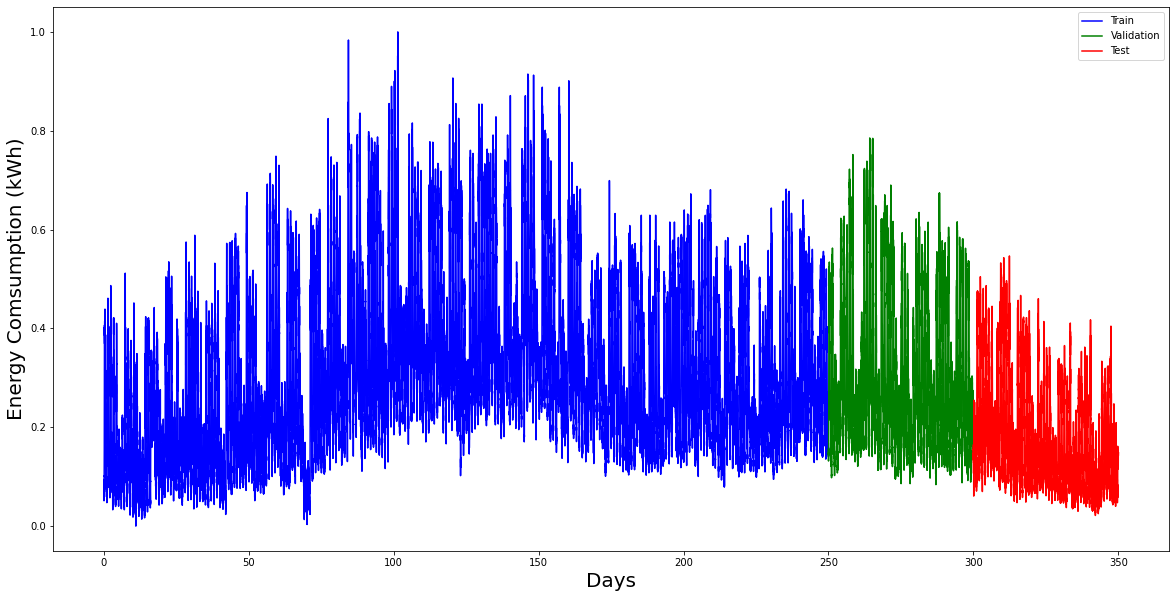

In [ ]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(df) + 1, 50*288)), labels = list(range(0, int(len(df)/288 + 1), 50)), size = 10)
plt.yticks(size = 10)
plt.plot(df_normalized[:288*250], color = 'blue')
plt.plot(df_normalized[288*250:288*300], color = 'green')
plt.plot(df_normalized[288*300:], color = 'red')
plt.legend(['Train', 'Validation', 'Test'])
plt.savefig('DataAnalysis/year_normalized_train_test_plot.png')

In [ ]:
months = []
for i in range(12):
  months.append(df_normalized['W'][288*30*i:288*30*(i+1)].to_list())

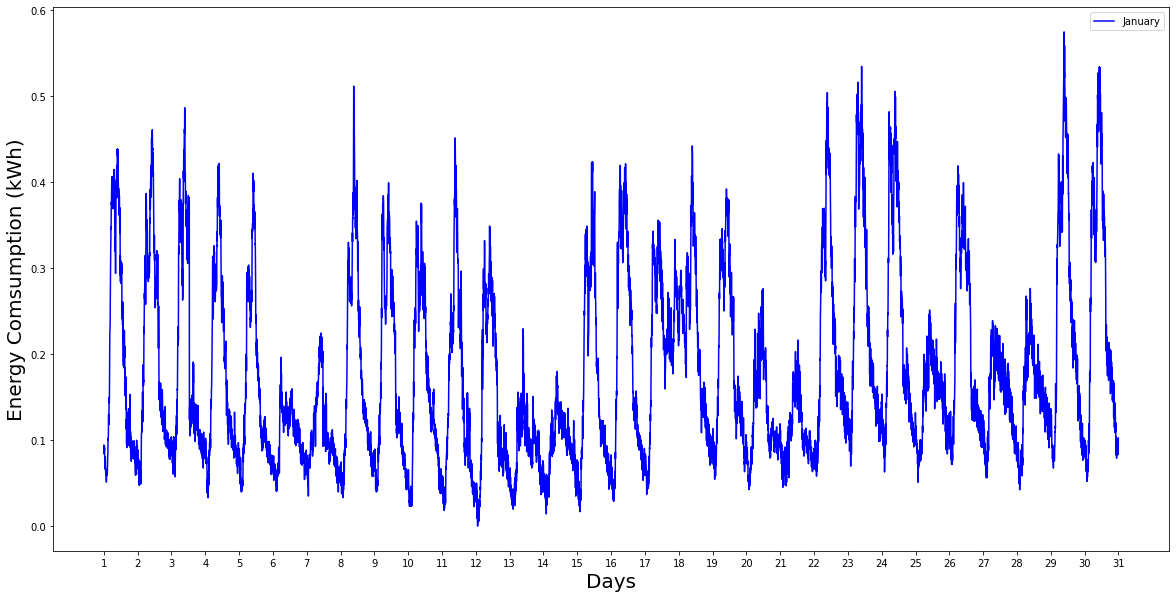

In [8]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, 30*288 + 1, 288)), labels = list(range(1, 32)), size = 10)
plt.yticks(size = 10)
plt.plot(months[0], color = 'blue')
plt.legend(['January'])
plt.savefig('DataAnalysis/january_plot_normalized.png')

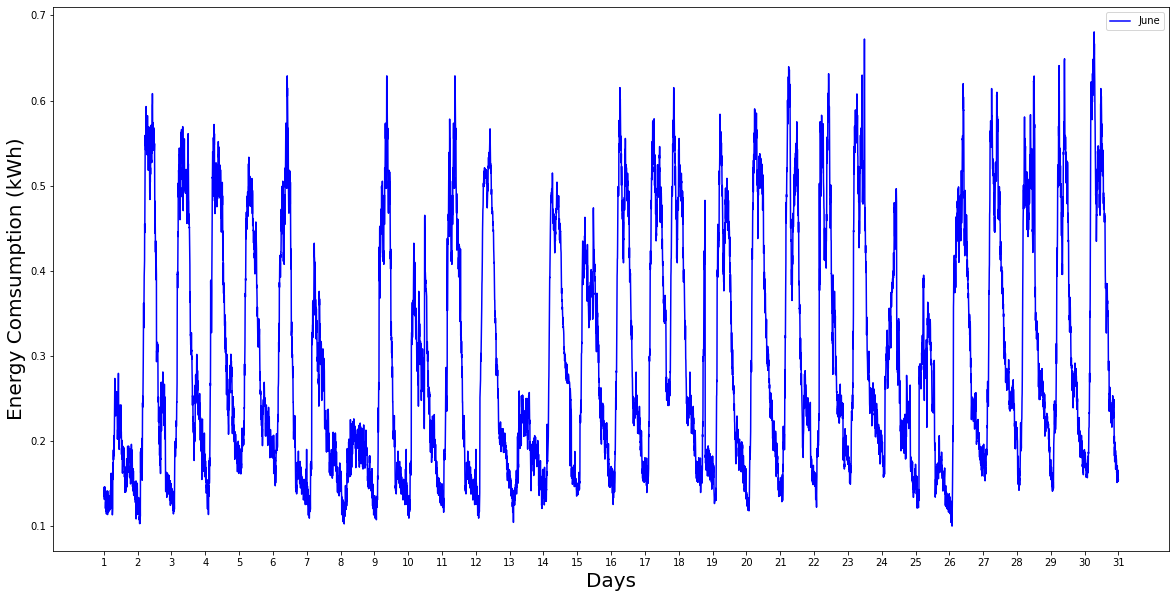

In [9]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, 30*288 + 1, 288)), labels = list(range(1, 32)), size = 10)
plt.yticks(size = 10)
plt.plot(months[6], color = 'blue')
plt.legend(['June'])
plt.savefig('DataAnalysis/june_plot_normalized.png')

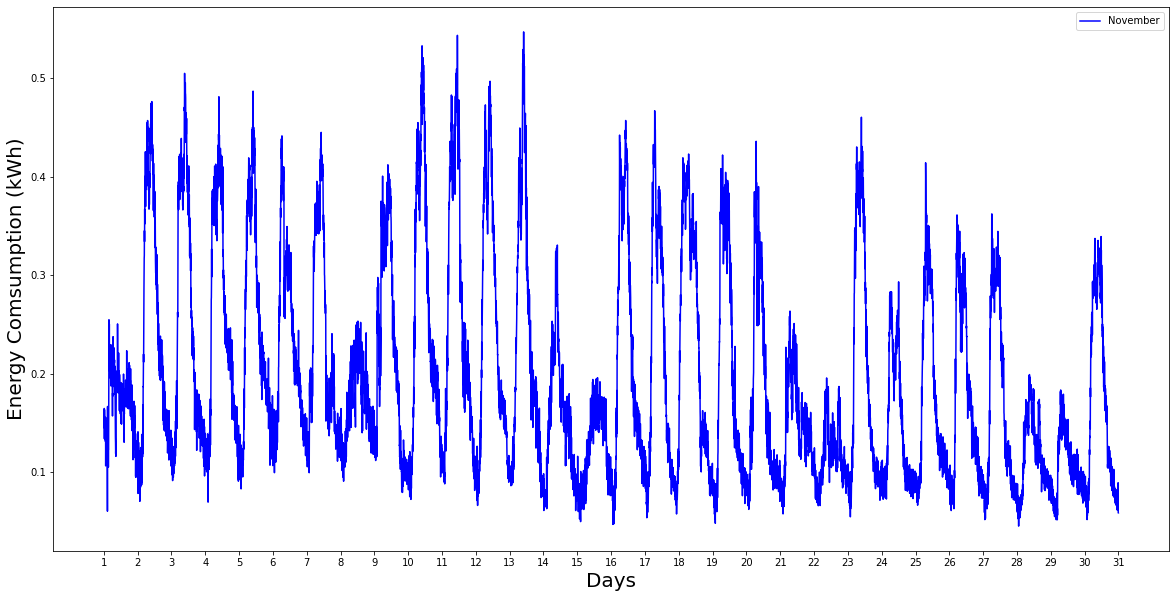

In [10]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, 30*288 + 1, 288)), labels = list(range(1, 32)), size = 10)
plt.yticks(size = 10)
plt.plot(months[10], color = 'blue')
plt.legend(['November'])
plt.savefig('DataAnalysis/november_plot_normalized.png')

In [ ]:
df_nan = po.read_csv('data/processed/2017_cleaned_for_imputation.csv')

In [ ]:
df_nan_normalized = po.DataFrame(scaler.fit_transform(df_nan['W'].values.reshape(-1, 1)), columns = ['W'])

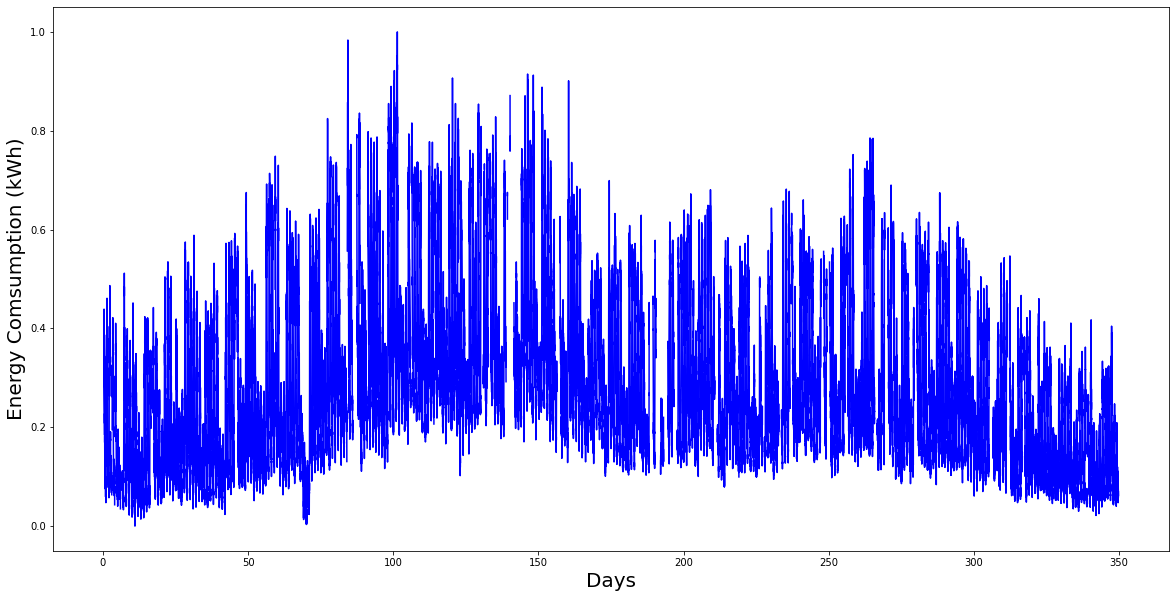

In [17]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(df) + 1, 50*288)), labels = list(range(0, int(len(df)/288 + 1), 50)), size = 10)
plt.yticks(size = 10)
plt.plot(df_nan_normalized['W'], color = 'blue')
plt.savefig('DataAnalysis/raw_data_before_imputation_normalized.png')

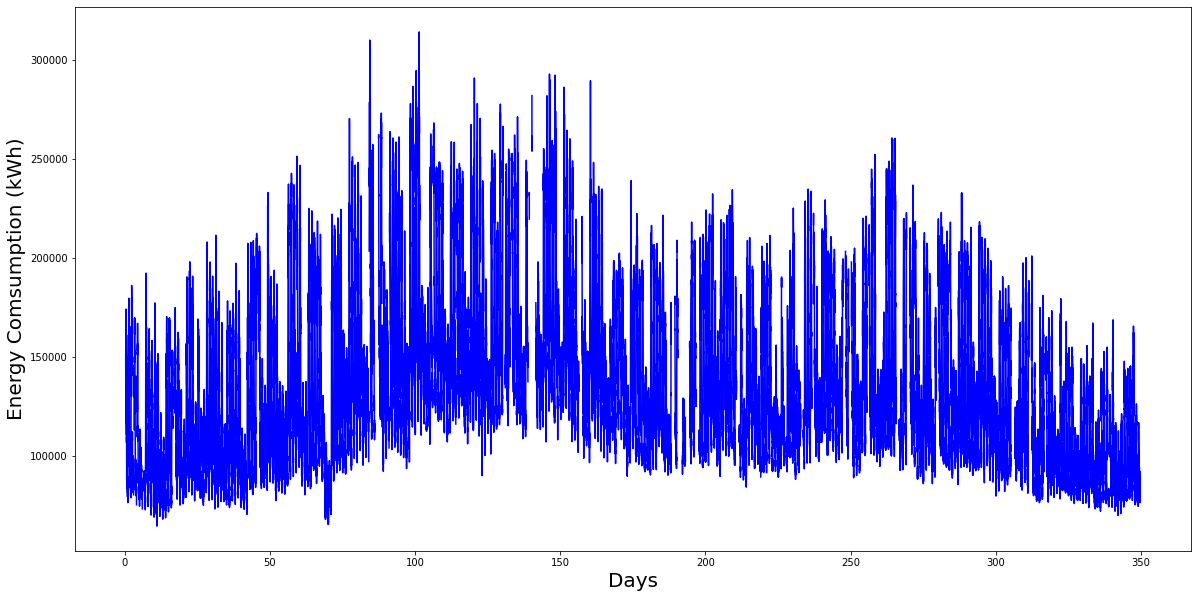

In [ ]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(df) + 1, 50*288)), labels = list(range(0, int(len(df)/288 + 1), 50)), size = 10)
plt.yticks(size = 10)
plt.plot(df_nan['W'], color = 'blue')
plt.savefig('DataAnalysis/raw_data_before_imputation.png')

In [ ]:
missing_values = np.where(np.isnan(df_nan['W']), df['W'], None)
missing_values_normalized = np.where(np.isnan(df_nan_normalized['W']), df_normalized['W'], None)

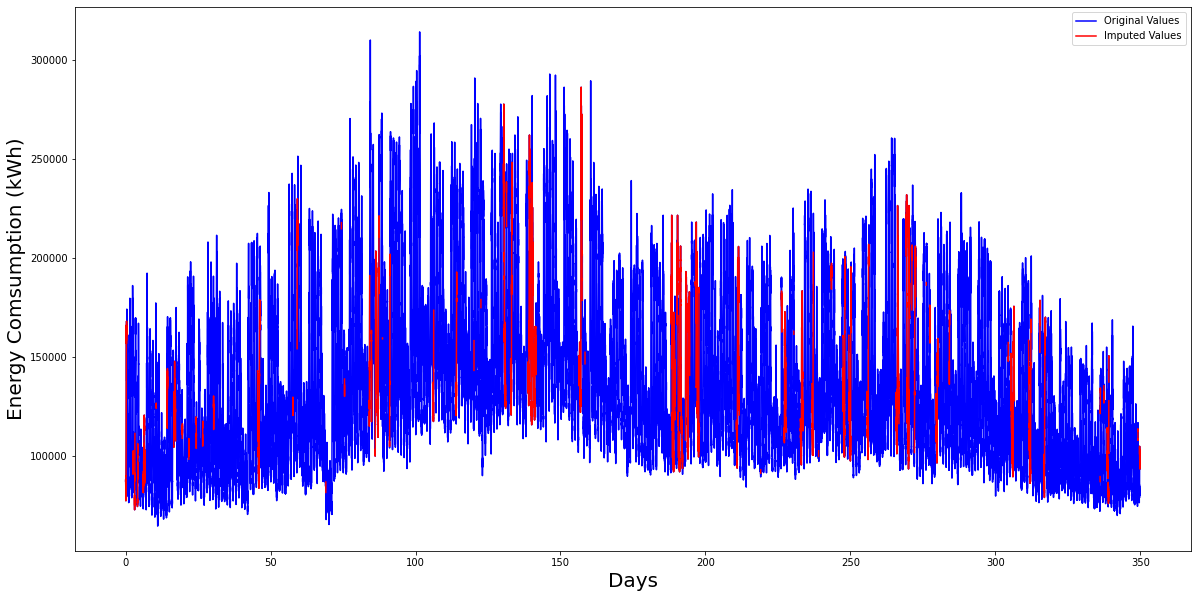

In [81]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(df) + 1, 50*288)), labels = list(range(0, int(len(df)/288 + 1), 50)), size = 10)
plt.yticks(size = 10)
plt.plot(df['W'], color = 'blue')
plt.plot(missing_values, color = 'red')
plt.legend(['Original Values', 'Imputed Values'])
plt.savefig('DataAnalysis/raw_data_eDTWBI_imputation.png')

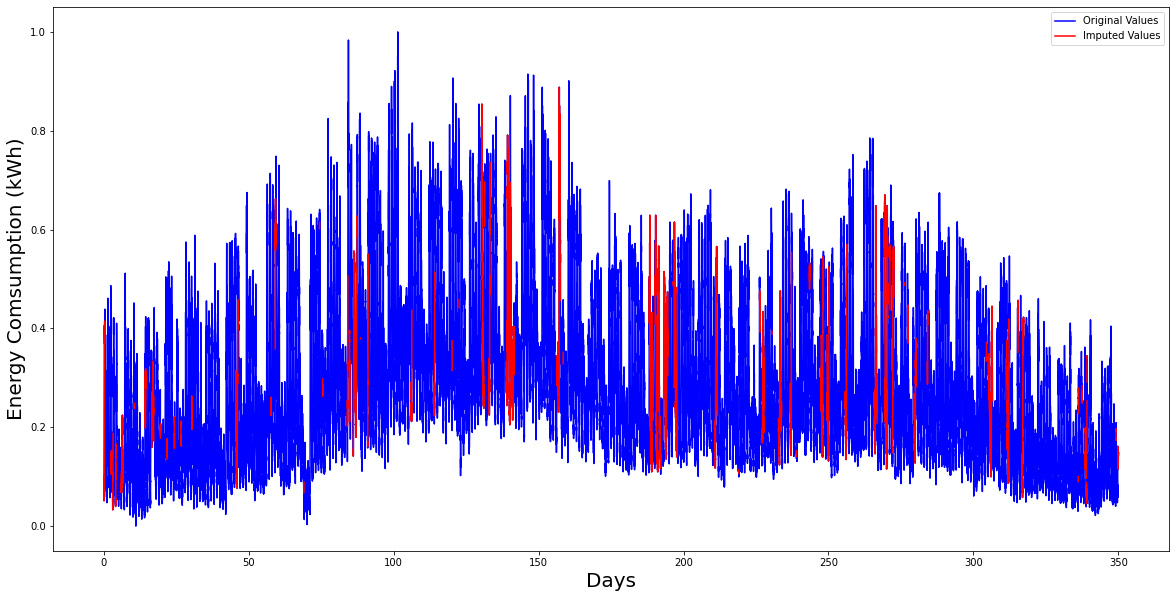

In [82]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(df) + 1, 50*288)), labels = list(range(0, int(len(df)/288 + 1), 50)), size = 10)
plt.yticks(size = 10)
plt.plot(df_normalized['W'], color = 'blue')
plt.plot(missing_values_normalized, color = 'red')
plt.legend(['Original Values', 'Imputed Values'])
plt.savefig('DataAnalysis/raw_data_normalized_eDTWBI_imputation.png')

In [ ]:
df_lin_interp = df_nan['W'].interpolate(method = 'linear', limit_direction = 'both')

In [ ]:
df_lin_interp_normalized = po.DataFrame(scaler.fit_transform(df_lin_interp.values.reshape(-1, 1)), columns = ['W'])

In [ ]:
interpolated_missing_values = np.where(np.isnan(df_nan['W']), df_lin_interp, None)
interpolated_missing_values_normalized = np.where(np.isnan(df_nan_normalized['W']), df_lin_interp_normalized['W'], None)

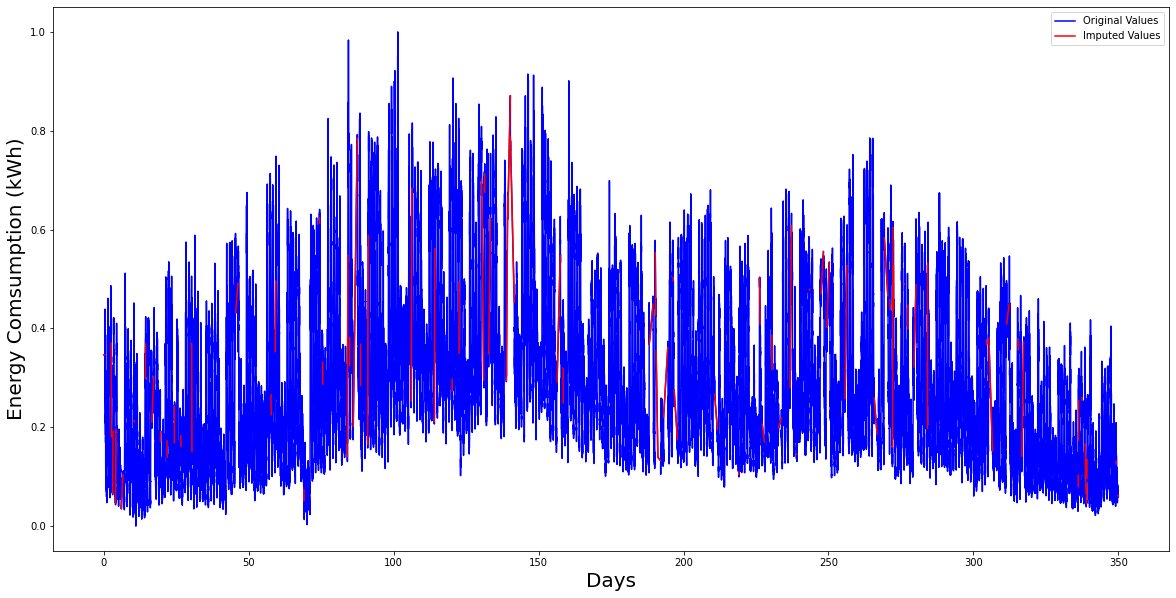

In [16]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(df) + 1, 50*288)), labels = list(range(0, int(len(df)/288 + 1), 50)), size = 10)
plt.yticks(size = 10)
plt.plot(df_lin_interp_normalized, color = 'blue')
plt.plot(interpolated_missing_values_normalized, color = 'red')
plt.legend(['Original Values', 'Imputed Values'])
plt.savefig('DataAnalysis/raw_data_linear_imputation_normalized.png')

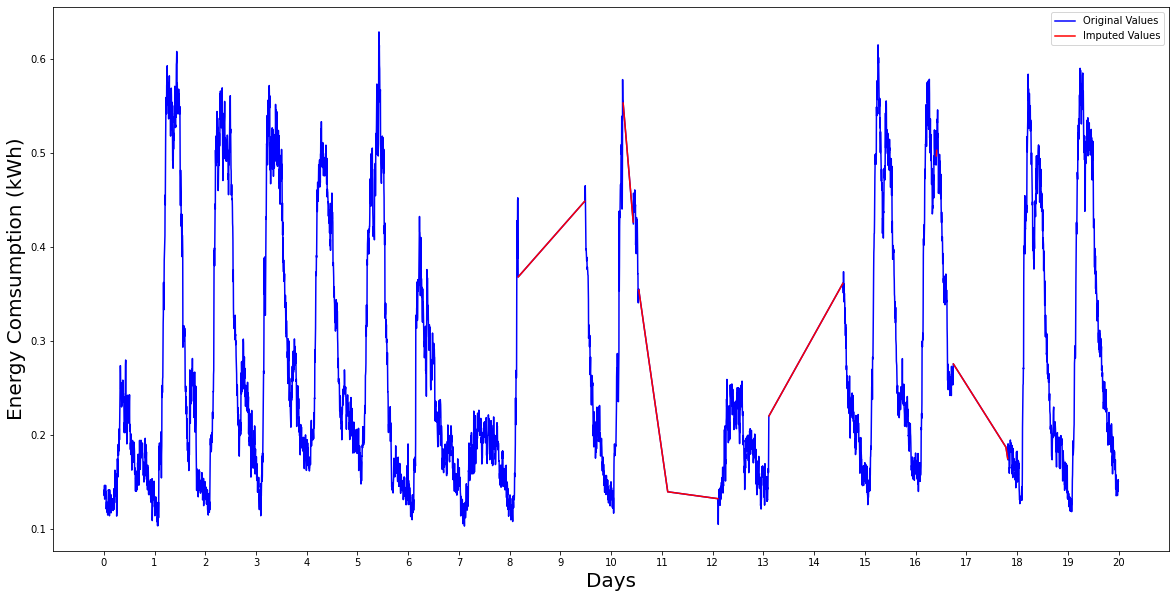

In [25]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, 288*21, 288)), labels = list(range(0, 21)), size = 10)
plt.yticks(size = 10)
plt.plot(df_lin_interp_normalized[288*180:288*200].reset_index(drop=True), color = 'blue')
plt.plot(interpolated_missing_values_normalized[288*180:288*200], color = 'red')
plt.legend(['Original Values', 'Imputed Values'])
plt.savefig('DataAnalysis/linear_imputation_problem_normalized.png')

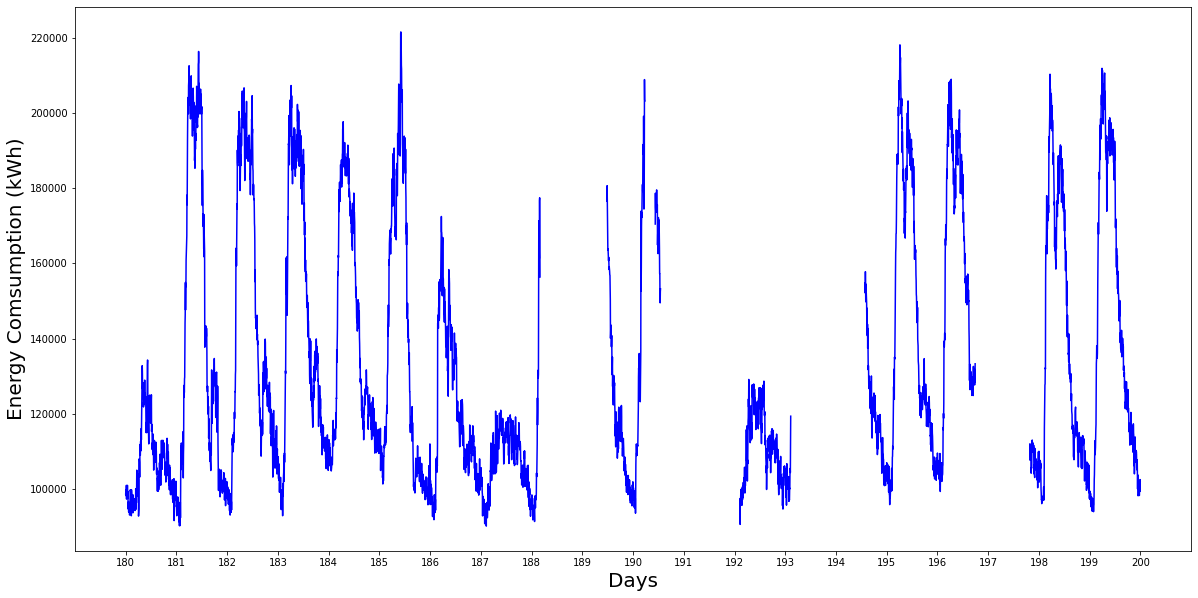

In [64]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(288*180, 288*201, 288)), labels = list(range(180, 201)), size = 10)
plt.yticks(size = 10)
plt.plot(df_nan[288*180:288*200]['W'], color = 'blue')
plt.savefig('DataAnalysis/lin_interp_region_before_interp.png')

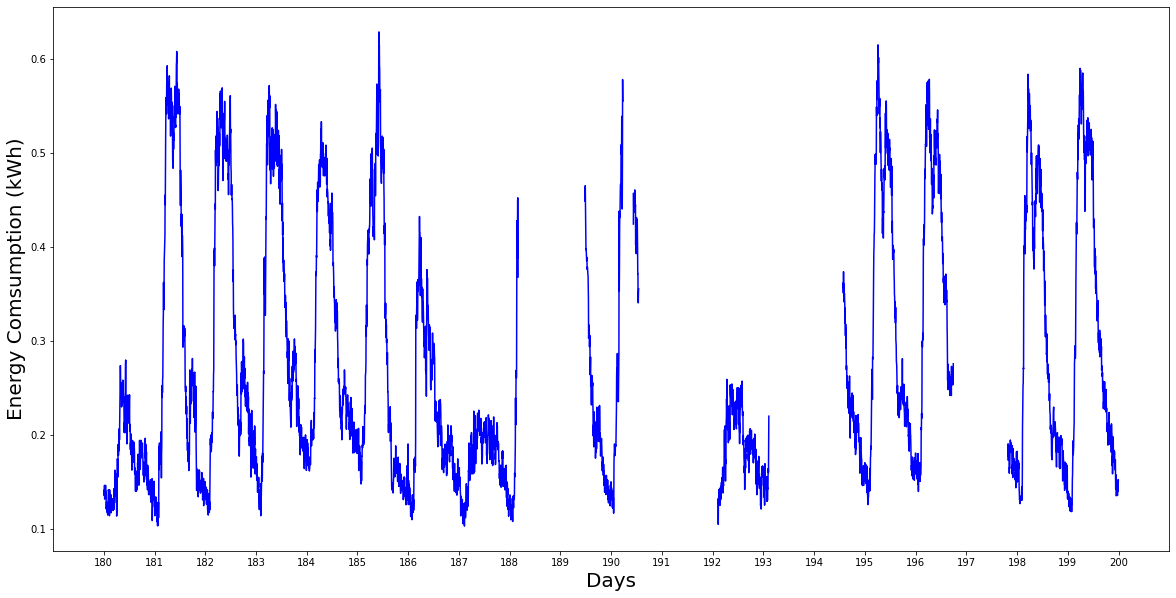

In [28]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(288*180, 288*201, 288)), labels = list(range(180, 201)), size = 10)
plt.yticks(size = 10)
plt.plot(df_nan_normalized[288*180:288*200], color = 'blue')
plt.savefig('DataAnalysis/lin_interp_region_before_interp_normalized.png')

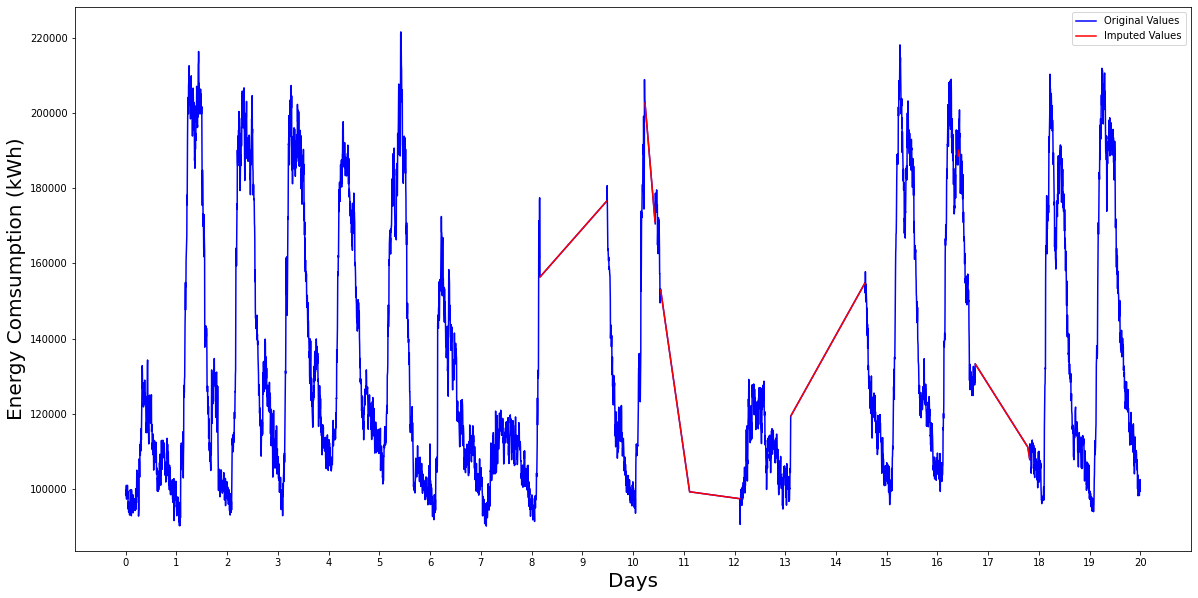

In [29]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, 288*21, 288)), labels = list(range(0, 21)), size = 10)
plt.yticks(size = 10)
plt.plot(df_lin_interp[288*180:288*200].reset_index(drop=True), color = 'blue')
plt.plot(interpolated_missing_values[288*180:288*200], color = 'red')
plt.legend(['Original Values', 'Imputed Values'])
plt.savefig('DataAnalysis/linear_imputation_problem.png')

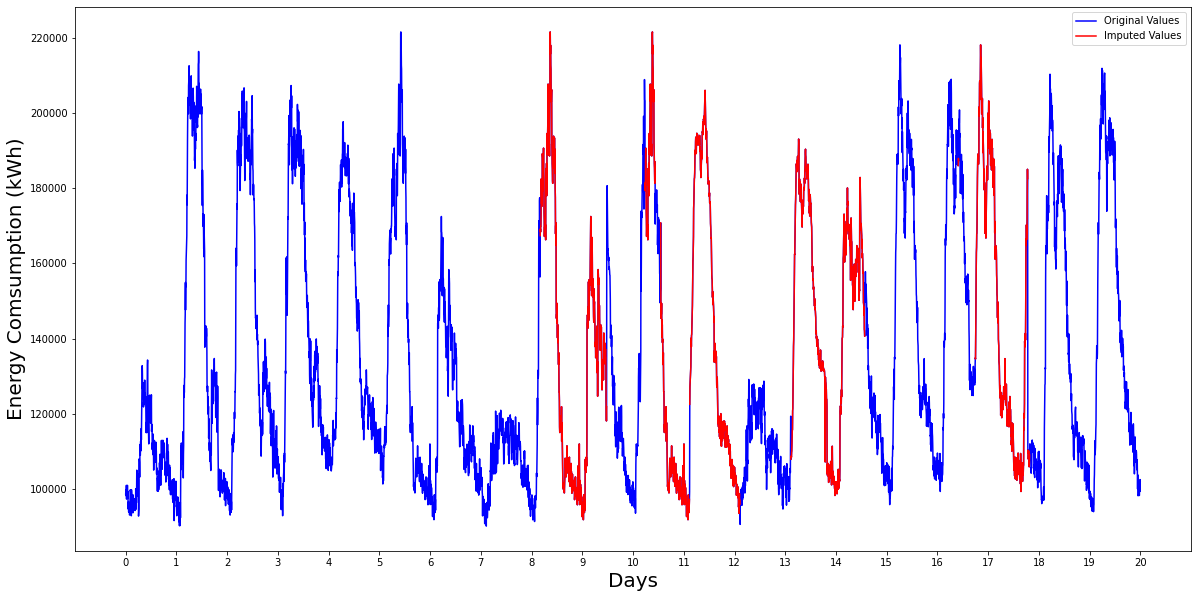

In [30]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, 288*21, 288)), labels = list(range(0, 21)), size = 10)
plt.yticks(size = 10)
plt.plot(df[288*180:288*200].reset_index(drop=True), color = 'blue')
plt.plot(missing_values[288*180:288*200], color = 'red')
plt.legend(['Original Values', 'Imputed Values'])
plt.savefig('DataAnalysis/edtwbi_for_region.png')

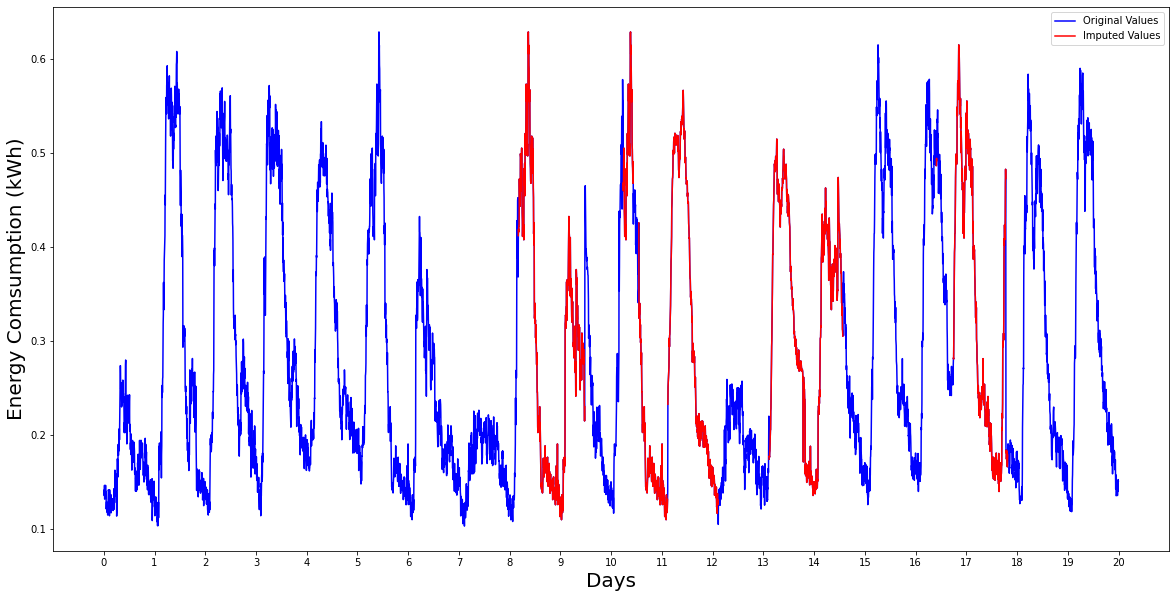

In [31]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, 288*21, 288)), labels = list(range(0, 21)), size = 10)
plt.yticks(size = 10)
plt.plot(df_normalized[288*180:288*200].reset_index(drop=True), color = 'blue')
plt.plot(missing_values_normalized[288*180:288*200], color = 'red')
plt.legend(['Original Values', 'Imputed Values'])
plt.savefig('DataAnalysis/edtwbi_for_region_normalized.png')

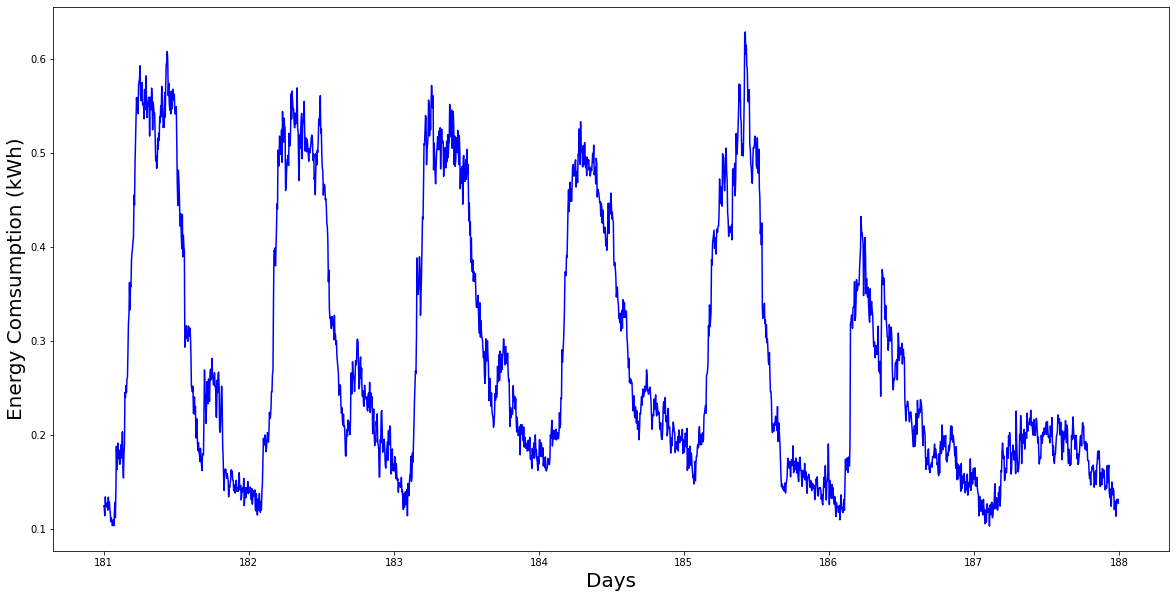

In [69]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(288*181, 288*189, 288)), labels = list(range(181, 189)), size = 10)
plt.yticks(size = 10)
plt.plot(df_normalized[288*181:288*188], color = 'blue')
plt.savefig('DataAnalysis/one_week_normalized.png')

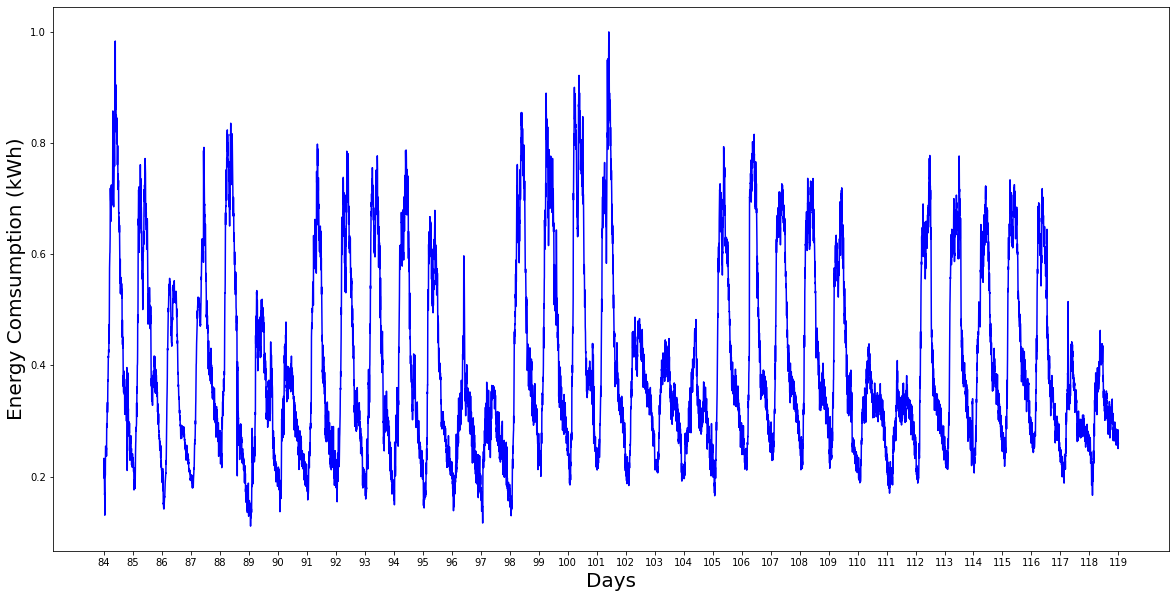

In [70]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(288*84, 288*120, 288)), labels = list(range(84, 120)), size = 10)
plt.yticks(size = 10)
plt.plot(df_normalized[288*84:288*119], color = 'blue')
plt.savefig('DataAnalysis/five_weeks_normalized.png')

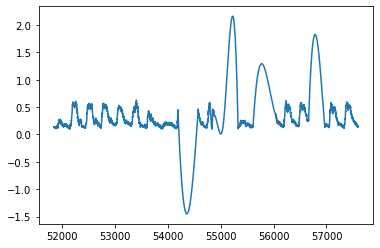

In [59]:
plt.plot(df_nan_normalized['W'][180*288:200*288].interpolate(method = 'cubic', limit_direction = 'both'))

In [4]:
stl_obj = STL(df.values, period=288)
decomp = stl_obj.fit()

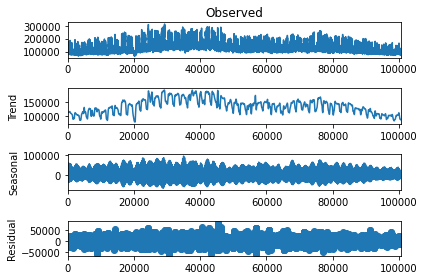

In [5]:
plots = decomp.plot()

In [21]:
trend_normalized = po.DataFrame(scaler.fit_transform(decomp.trend.reshape(-1, 1)))
seasonal_normalized = po.DataFrame(scaler.fit_transform(decomp.seasonal.reshape(-1, 1)))
residual_normalized = po.DataFrame(scaler.fit_transform(decomp.resid.reshape(-1, 1)))

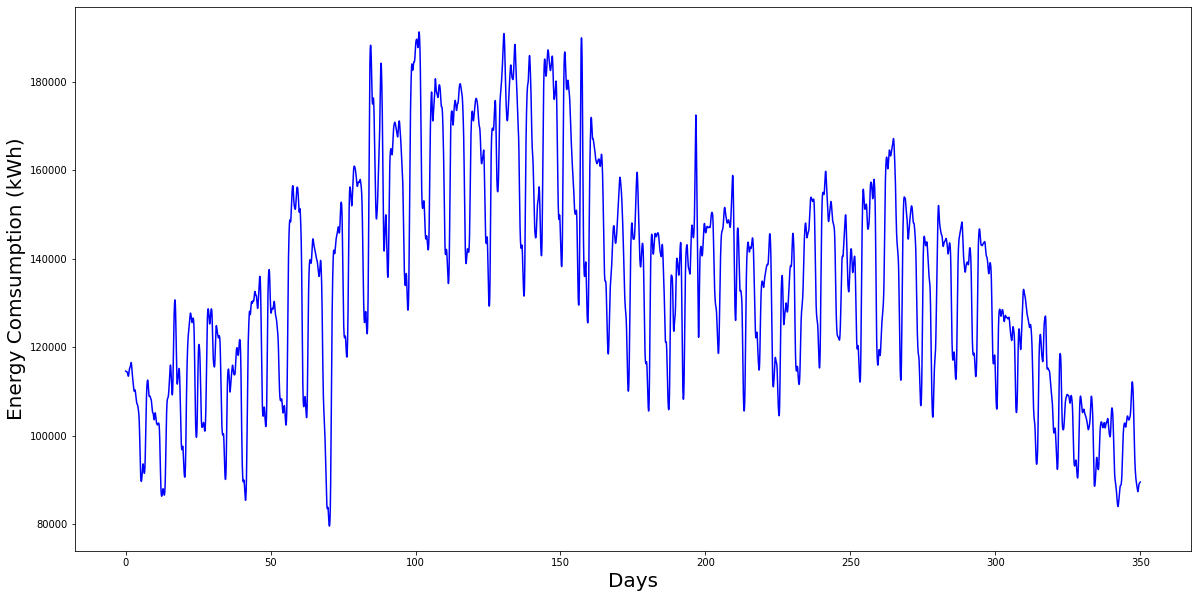

In [25]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(df) + 1, 50*288)), labels = list(range(0, int(len(df)/288 + 1), 50)), size = 10)
plt.yticks(size = 10)
plt.plot(decomp.trend, color = 'blue')
plt.savefig('DataAnalysis/stl_decomp_trend_component.png')

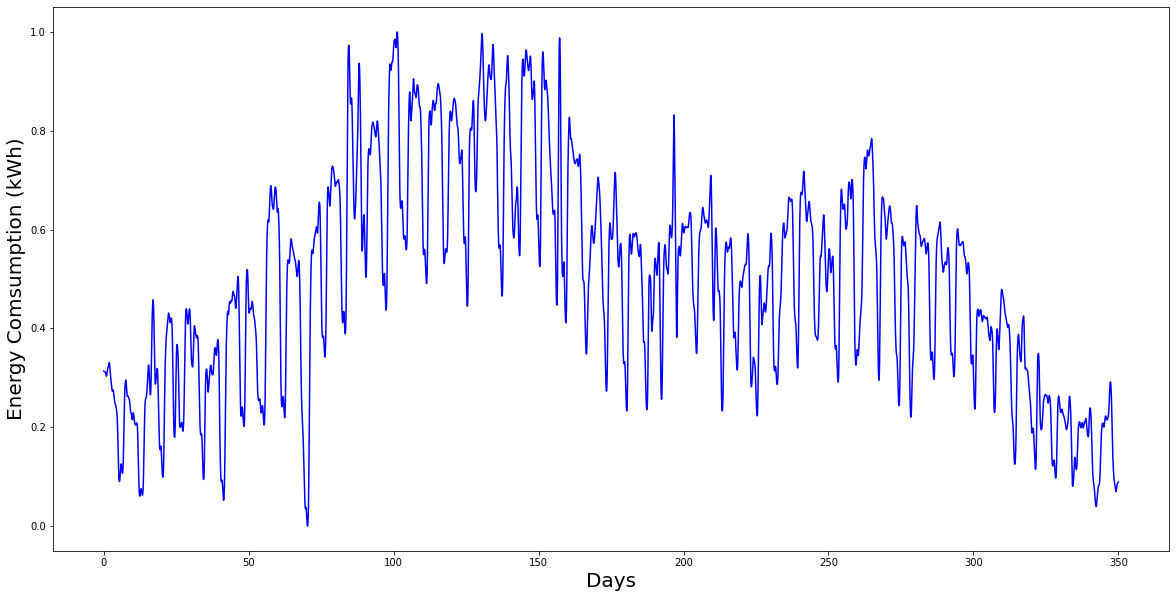

In [26]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(df) + 1, 50*288)), labels = list(range(0, int(len(df)/288 + 1), 50)), size = 10)
plt.yticks(size = 10)
plt.plot(trend_normalized, color = 'blue')
plt.savefig('DataAnalysis/stl_decomp_trend_component_normalized.png')

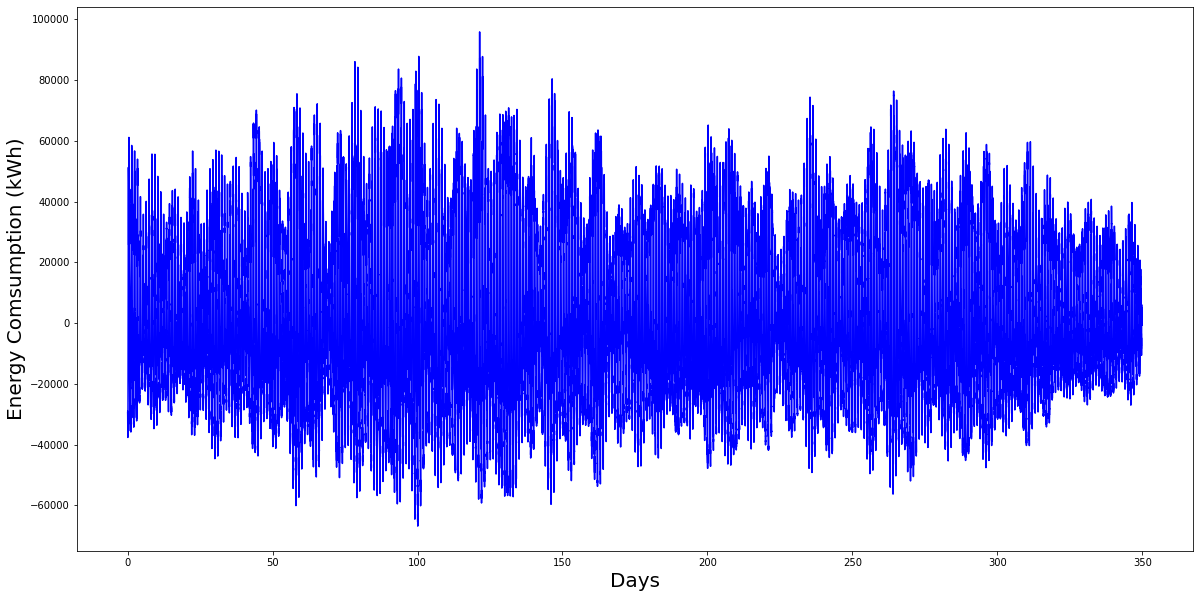

In [27]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(df) + 1, 50*288)), labels = list(range(0, int(len(df)/288 + 1), 50)), size = 10)
plt.yticks(size = 10)
plt.plot(decomp.seasonal, color = 'blue')
plt.savefig('DataAnalysis/stl_decomp_seasonal_component.png')

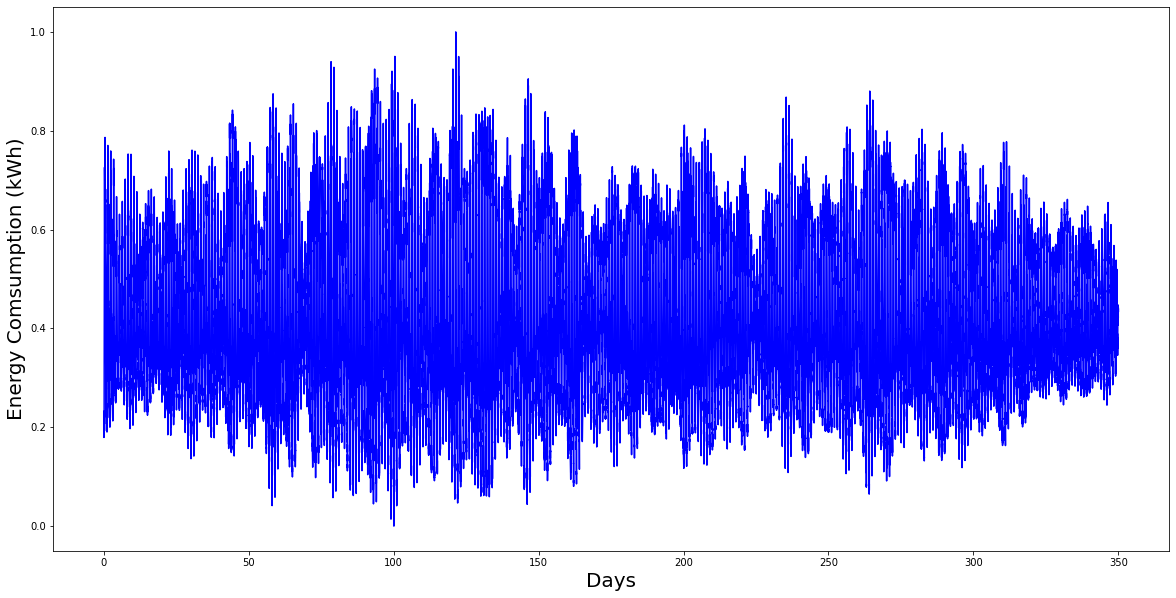

In [28]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(df) + 1, 50*288)), labels = list(range(0, int(len(df)/288 + 1), 50)), size = 10)
plt.yticks(size = 10)
plt.plot(seasonal_normalized, color = 'blue')
plt.savefig('DataAnalysis/stl_decomp_seasonal_component_normalized.png')

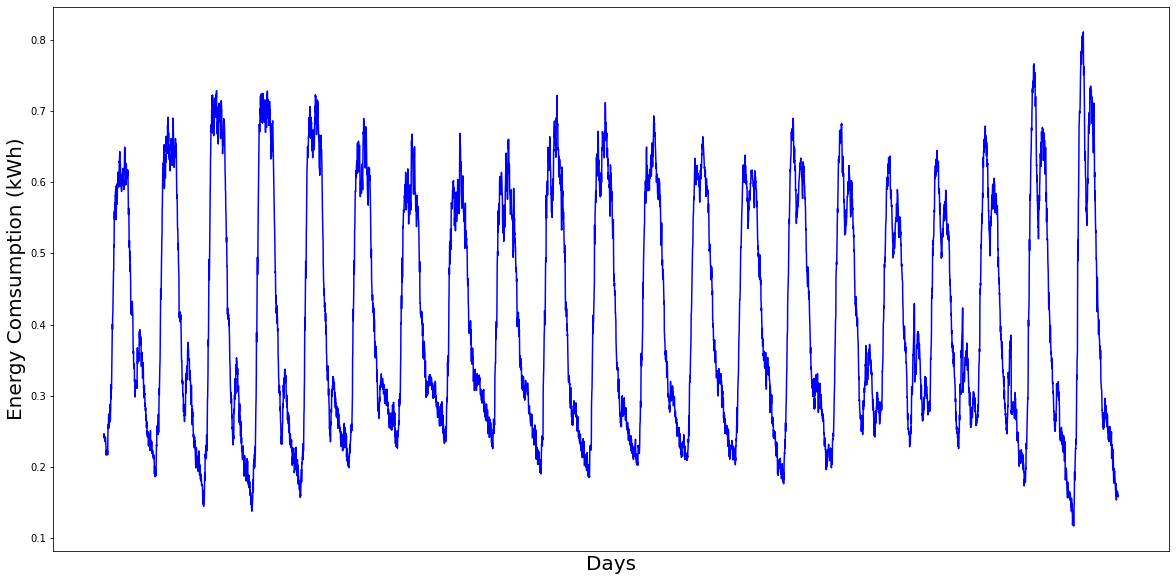

In [29]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(288*0, 288*22, 288)), labels = list(range(0, 22)), size = 10)
plt.yticks(size = 10)
plt.plot(seasonal_normalized[180*288:201*288], color = 'blue')
plt.savefig('DataAnalysis/stl_decomp_seasonal_component_3_weeks_normalized.png')

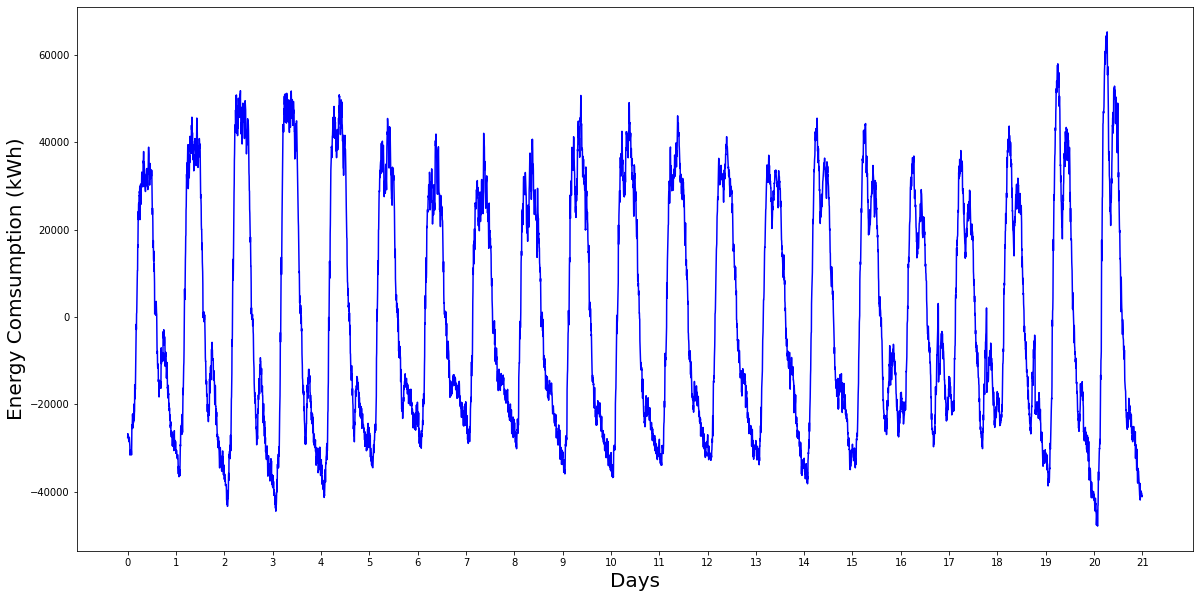

In [16]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(288*0, 288*22, 288)), labels = list(range(0, 22)), size = 10)
plt.yticks(size = 10)
plt.plot(decomp.seasonal[180*288:201*288], color = 'blue')
plt.savefig('DataAnalysis/stl_decomp_seasonal_component_3_weeks.png')

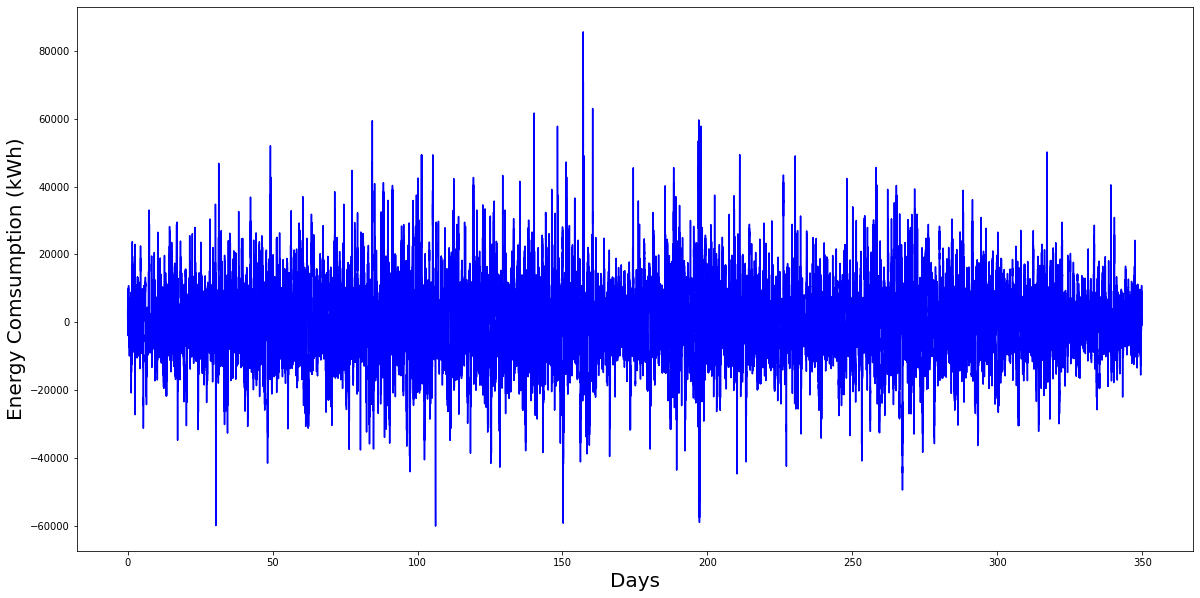

In [33]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(df) + 1, 50*288)), labels = list(range(0, int(len(df)/288 + 1), 50)), size = 10)
plt.yticks(size = 10)
plt.plot(decomp.resid, color = 'blue')
plt.savefig('DataAnalysis/stl_decomp_residual_component.png')

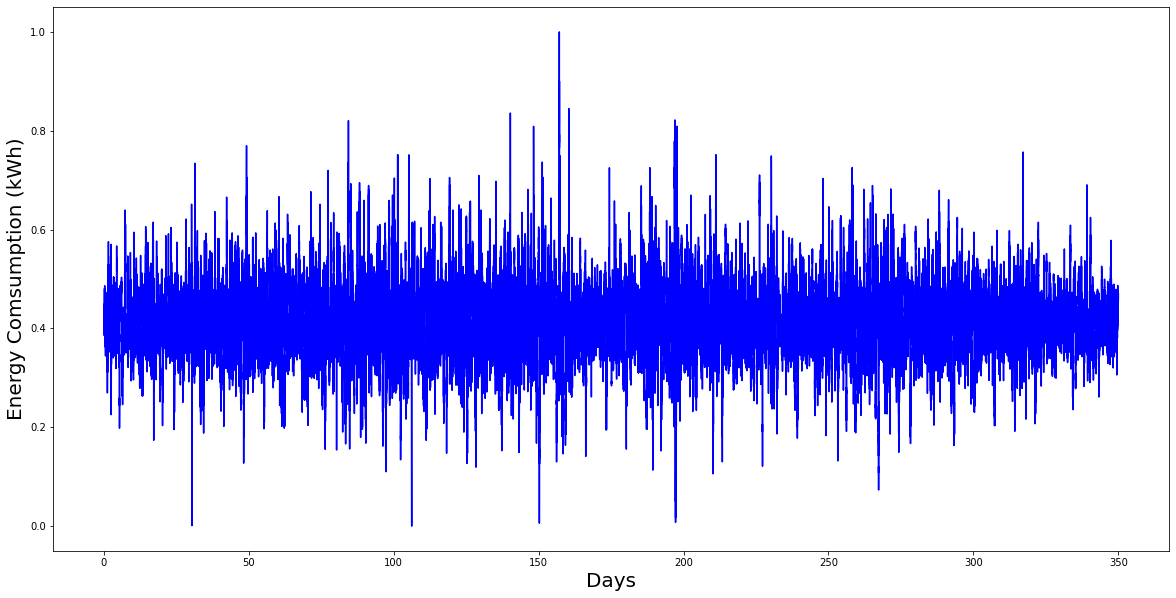

In [34]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(df) + 1, 50*288)), labels = list(range(0, int(len(df)/288 + 1), 50)), size = 10)
plt.yticks(size = 10)
plt.plot(residual_normalized, color = 'blue')
plt.savefig('DataAnalysis/stl_decomp_residual_component_normalized.png')

In [36]:
np.random.rand(3,3,3).reshape(27, -1)

array([[0.24246793],
       [0.39747457],
       [0.41031393],
       [0.7986617 ],
       [0.66067152],
       [0.55321143],
       [0.59049243],
       [0.48727956],
       [0.31559955],
       [0.56815199],
       [0.37343398],
       [0.74646364],
       [0.78697007],
       [0.3734572 ],
       [0.73871088],
       [0.40627554],
       [0.64715708],
       [0.18210624],
       [0.62656935],
       [0.5240542 ],
       [0.79155804],
       [0.0349335 ],
       [0.84667842],
       [0.2077627 ],
       [0.0697038 ],
       [0.39667035],
       [0.75200921]])